In [1]:
# old data format
"""from utils.data import remove_outliers, load_ucr_dataset

# load data to work with here
#data = normalize_datasets(load_ucr_archive())
data = load_ucr_dataset(47).normalize()
#data = normalize_datasets(load_gbnc_ngrams_as_datasets())

data_lof = remove_outliers(data)
"""

'from utils.data import remove_outliers, load_ucr_dataset\n\n# load data to work with here\n#data = normalize_datasets(load_ucr_archive())\ndata = load_ucr_dataset(47).normalize()\n#data = normalize_datasets(load_gbnc_ngrams_as_datasets())\n\ndata_lof = remove_outliers(data)\n'

In [2]:
from utils.data import remove_outliers, load_ucr_dataset

data = load_ucr_dataset(47)
data_lof = data
for index, row in data_lof.iterrows():
    row['data'] = remove_outliers(row['data'])

In [3]:
# set other important global information here
eps = 0.0000001
#eps = 0.000001


In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]


n = 3  # degree of the spline
p = 8  # number of internal knots

knots = flatten((n + 1) * [[0]] + [[x / (p + 1)] for x in range(1, p + 1)] + (n + 1) * [[1]])

m = len(knots) - 1 - n  # number of control points (coefficients)

In [5]:
import matplotlib.colors as mcolors

print(mcolors)

<module 'matplotlib.colors' from 'C:\\Users\\veron\\Desktop\\Bachelorarbeit_Info\\Code\\splineRegressionExperiments\\venv\\Lib\\site-packages\\matplotlib\\colors.py'>


The following function calculates different accuracy metrics for the different fitting method and returns them as a 2D array (one column for each fitting method).

In [6]:
import scipy
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline, calculate_max_dist
from utils.fit import fit_max_spline, fit_max_l1_spline


def calculate_errors(data_tuples, knots, n):
    result1 = scipy.interpolate.make_lsq_spline([x[0] for x in data_tuples], [x[1] for x in data_tuples], knots, k=n).c
    result2 = fit_max_spline(data_tuples, knots, n)[1]
    result3 = fit_max_l1_spline(data_tuples, knots, n, eps=eps)[1]

    results = [result1, result2, result3]

    errors = []
    data_points = [x[1] for x in data_tuples]
    counter = 0
    for result in results:
        counter += 1
        fitted_spline = [evaluate_spline(knots, result, n, x[0]) for x in data_tuples]  #data_points]
        max_dist = calculate_max_dist(knots, result, n, data_tuples)[0]
        errors.append([max_dist,  # maximum absolute distance,
                       mean_squared_error(data_points, fitted_spline),  # MSE
                       sqrt(mean_squared_error(data_points, fitted_spline)),  # RMSE
                       mean_absolute_error(data_points, fitted_spline)  # MAE
                       ])

    return errors

Here, the accuracy metrics are averaged for a whole dataset.

In [7]:
%%time
from math import sqrt
import pandas as pd
import numpy as np

assert (len(data) == len(data_lof))

# fit spline and measure errors
all_errors = []
for i in range(len(data)):
    errors = calculate_errors(data[i], knots, n)  #+ calculate_errors(data_lof[i], knots, n)
    all_errors.append(errors)

#row_names = ['LSQ', 'LSQ w/o outliers', 'Max', 'Max w/o outliers', 'Max and L1', 'Max and L1 w/o outliers']
row_names = ['LSQ', 'Max', 'Max and L1']

avg_errors = np.array([
    [sum(all_errors[x][i][j] for x in range(len(all_errors))) / len(all_errors) for j in range(len(all_errors[0][0]))]
    for i in range(len(all_errors[0]))
])

df = pd.DataFrame(avg_errors, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
df.columns = pd.MultiIndex.from_product([['avg. measures'], df.columns])
df.index = row_names
print(df)
print("n:", n)
print("p:", p)
print("eps:", eps)


KeyError: 0

In [8]:
import numpy as np
import matplotlib.colors as mcolors


def plot_splines(axis, data, labels='None'):
    result1 = scipy.interpolate.make_lsq_spline([x[0] for x in data], [x[1] for x in data], knots, k=n).c
    t, result2 = fit_max_spline(data, knots, n)
    result3 = fit_max_l1_spline(data, knots, n, eps=eps)[1]

    results = [result1, result2, result3]
    max_dists = [calculate_max_dist(knots, result, n, data)[0] for result in results]
    colors = list(mcolors.BASE_COLORS.keys())

    xs = np.linspace(0, 1, num=1000)

    print("opt distance", t)

    for i in range(len(results)):
        axis.plot(xs, [evaluate_spline(knots, results[i], n, x) for x in xs], colors[i % len(colors)] + '-',
                  label=labels[i])
        axis.plot(xs, [evaluate_spline(knots, results[i], n, x) + max_dists[i] for x in xs],
                  colors[i % len(colors)] + '--')
        axis.plot(xs, [evaluate_spline(knots, results[i], n, x) - max_dists[i] for x in xs],
                  colors[i % len(colors)] + '--')

    axis.scatter([d[0] for d in data], [d[1] for d in data], marker='.')
    print("number of data points:", len(data))
    axis.legend()

In [9]:
from matplotlib import pyplot as plt

row_names = ['LSQ', 'Max', 'Max and L1']
fitting_methods = [r'$L_2$', r'$L_{\infty}$', r'$L_{\infty}$ and $L_1$']
# single plot
for data_tuples in data:
    plot_splines(plt, data_tuples, fitting_methods)

    error_metrics = calculate_errors(data_tuples, knots, n)
    df = pd.DataFrame(error_metrics, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
    df.index = row_names
    print(df)

    plt.show()

IndexError: string index out of range

Both the original data and the data without outliers are plotted here.

KeyError: 0

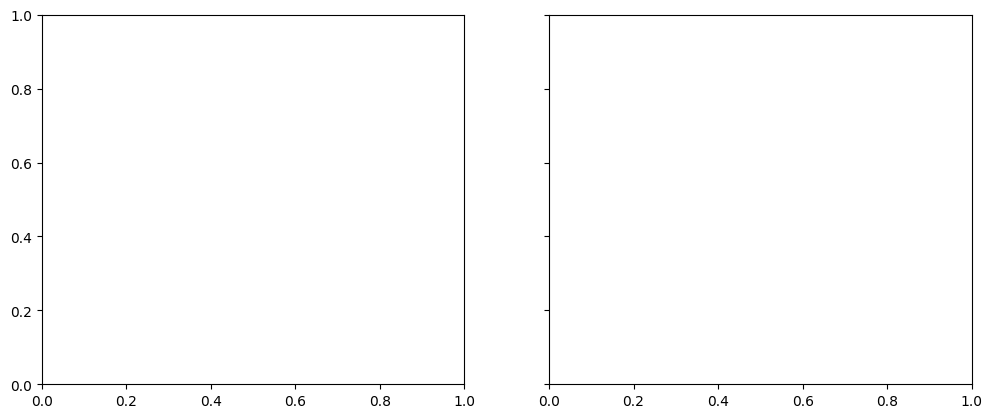

In [10]:
from matplotlib import pyplot as plt

fitting_methods = [r'$L_2$', r'$L_{\infty}$', r'$L_{\infty}$ and $L_1$']
# plot data and data without outliers next to each other
assert (len(data) == len(data_lof))
for i in range(len(data)):
    f, axes = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(12)

    error_metrics = calculate_errors(data[i], knots, n)
    df1 = pd.DataFrame(error_metrics, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
    df1.index = row_names
    print(df1)

    plot_splines(axes[0], data[i], fitting_methods)
    axes[0].set_title("Data including outliers")
    #axes[0].table(cellText=df1.values.round(4), colLabels=df1.columns)

    error_metrics = calculate_errors(data_lof[i], knots, n)
    df2 = pd.DataFrame(error_metrics, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
    df2.index = row_names
    print(df2)

    plot_splines(axes[1], data_lof[i], fitting_methods)
    axes[1].set_title("Data without outliers")
    #axes[1].table(cellText=df2.values.round(4), colLabels=df2.columns)

    plt.subplots_adjust(bottom=0.25, top=0.95)

    plt.show()